**Notebook Author: Tejumade Afonja, Project Lead**

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

In [2]:
def combine_completions(files_dir, split_file=2):
    json_files = glob(files_dir+'/*.json', recursive=True)
    dataset = {'id': [], 'lead_time': [], 'label': [], 'comments': [], 'audio_filename': []}

    for json_file in json_files:
        with open(json_file, 'r') as f:
            data = json.load(f)
            completions = data['completions'][0]

            dataset['id'].append(data['id'])
            dataset['lead_time'].append(completions['lead_time'])

            if len(completions['result']) == 1:
                dataset['label'].append(completions['result'][0]['value']['choices'][0])
                dataset['comments'].append('')
            else:  
                for item in completions['result']:
                    if item['type'] == 'textarea':
                        dataset['comments'].append(item['value']['text'][0])
                    elif item['type'] == 'choices':
                        dataset['label'].append(item['value']['choices'][0])  
                    else:
                        print(dataset)
            if len(completions['result']) < 1:
                print(data)
            dataset['audio_filename'].append(data['data']['url'].split('/')[split_file].split('?')[0])
    return dataset

**Teju**

In [3]:
teju_completions = combine_completions('/Users/s3nsei/sauti-db2/completions/')
len(teju_completions['label'])

1615

In [4]:
df_tej = pd.DataFrame(teju_completions)
df_tej.head()

,id,lead_time,label,comments,audio_filename
0,729,4.513,Bad,repetition,1606333777169_REC1606333771189.wav
1,683,6.923,Good,,1605983021519_REC1605983020371.wav
2,379,12.929,Good,,1605990872650_REC1605990856404.wav
3,396,5.393,Good,,1606564137934_REC1606564131614.wav
4,1209,11.057,Good,,1605859786366_REC1605859774642.wav


In [5]:
df_tej['label'].value_counts()

Good            1154
Bad              245
I don't know     216
Name: label, dtype: int64

In [6]:
# Teju had some comments when she labeled
df_tej[df_tej.comments.str.len() > 0 ]['comments'][:20]

0                                  repetition
7                         unfinished sentence
10                  sounds like a brief pause
11                                 repetition
14                            little bg sound
15                               didnt finish
18            "only" is hardly understandable
19                           microphone sound
21                   repeated sentences twice
22                                 low volume
23    repetition I think and background noise
26                               not so sharp
28                                 repetition
29                almost unfinished last word
32                            little bg sound
34                 Double channel, good audio
42                                 low volume
43                   hissing background noise
45                       repetition but clean
51                                 low volume
Name: comments, dtype: object

Teju did an initial labelling of all the audio samples by creating a labelling task with 3 choices - Good, Bad, and Not Sure. She also provided some comments which were then used by Iroro for his labelling task. Iroro further reduced the number of samples with 2 choices - Good and Bad.

**Iroro**

In [7]:
iroro_completions = combine_completions('/Users/s3nsei/Downloads/sauti-db-iroro/completions/', split_file=4)
len(iroro_completions['label'])

1619

In [8]:
df_iroro = pd.DataFrame(iroro_completions)
df_iroro.head()

,id,lead_time,label,comments,audio_filename
0,729,4.964,Good,,1605997780005_REC1605997778729.wav
1,683,4.606,Bad,,1605873044196_REC1605873020304.wav
2,379,5.317,Good,,1605979389823_REC1605979383437.wav
3,396,5.296,Bad,,1606049287495_REC1606049282023.wav
4,1209,11.197,Good,,1606297541406_REC1606297537644.wav


In [9]:
df_iroro.label.value_counts()

Good    972
Bad     647
Name: label, dtype: int64

Iroro rejected the audio files based on the following conditions:

- Repetition of words, stuttering or self-editing during reading. It is best to read the thing fluently. Otherwise, the text transcript from Arctic will not match the audio!

- Distortion on speech (from codec or other elements of the recording chain), sometimes the distortion is just on the front/attack portion of each vocalization.
- Transient distortion (clicks/pops/), whistling sounds, non-stationary noise in background (like Danfo driving by)
- Breathing or turbulent noise on microphone, proximity effect on microphone 
- Audio gating effect on the microphone/recording-software
- Singing or loud discussion in the background. Basically, if an ASR can attempt to transcribe that background noise, it's not suitable for training a TTS.
- Muffled or unintelligible speech
- Very very quiet (will not normalize well)
- Cut off words or incomplete sentences
- Noise immediately the microphone open is an indication of a very noisy and potentially unusable file.


Other issue to deal with during preprocessing
- leading silence, most audio had at least 2-3 seconds of leading or trailing silence

In [10]:
# df_iroro[df_iroro.label=='Good'].reset_index()['audio_filename'].to_csv('/Users/s3nsei/sauti_wavs/good_labels.txt', header=None, index=None)
# df_iroro[df_iroro.label=='Bad'].reset_index()['audio_filename'].to_csv('/Users/s3nsei/sauti_wavs/bad_labels.txt', header=None, index=None)

We have created two additional paid labelling jobs for the "Good" audio samples. The labellers are external participants from the AI Sarturdays Lagos community.

In [11]:
def combine_completions2(files_dir):
    json_files = glob(files_dir+'/*.json', recursive=True)
    dataset = {'id': [], 
               'lead_time': [], 
               'sentence_id': [],
               'background_noise_level': [], 
               'audio_volume_level': [], 
               'gender': [], 
               'label':[], 
               'speech_type': [],
               'audio_filename': []}

    for json_file in json_files:
        with open(json_file, 'r') as f:
            data = json.load(f)
            completions = data['completions'][0]
            
            dataset['id'].append(data['id'])
            dataset['lead_time'].append(completions['lead_time'])
            dataset['audio_filename'].append(data['data']['url'].split('/')[2].split('.')[0])
            
            from_names = [i['from_name'] for i in completions['result']]
            
            if 'noise' not in from_names:
                dataset['background_noise_level'].append("0")
            
            if 'choices' not in from_names:
                dataset['speech_type'].append("None")
            
            if 'volume' not in from_names:
                dataset['audio_volume_level'].append("0")
            
            if 'gender' not in from_names:
                print('No Gender defined')
                print(data['id'])
                
            elif 'sentence_id' not in from_names:
                print('No sentenceID defined, appended "NA"')
                print(data['id'])
                dataset['sentence_id'].append("NA")
                
                
            
            for result in completions['result']:
                
                if result['from_name'] == 'noise':
                    dataset['background_noise_level'].append(result['value']['choices'][0].strip("'"))
            
                    
                elif result['from_name'] == 'sentence_id':
                    dataset['sentence_id'].append(result['value']['text'][0])
                
                elif result['from_name'] == 'volume':
                    dataset['audio_volume_level'].append(result['value']['choices'][0].strip("'"))
                    
                elif result['from_name'] == 'choices':
                    dataset['speech_type'].append(result['value']['choices'][0])

                elif result['from_name'] == 'gender':
                    dataset['gender'].append(result['value']['choices'][0])
                    
                elif result['from_name'] == 'label':
                    dataset['label'].append(result['value']['choices'][0])
                                    
    return dataset

**Labeller 8887: "Female" and Labeller 8888: "Male"**

In [12]:
dataset_8887 = combine_completions2('/Users/s3nsei/label_completions/completions_8887/')

No sentenceID defined, appended "NA"
588


In [13]:
labeller_8887 = pd.DataFrame(dataset_8887)
labeller_8887.head()

,id,lead_time,sentence_id,background_noise_level,audio_volume_level,gender,label,speech_type,audio_filename
0,729,61.270,arctic_b0486,2,5,M,Good,Intellegible,1605959626155_REC1605959624750
1,683,162.874,arctic_b0135,2,3,F,Good,Intellegible,1605620545718_REC1605620543614
2,379,49.647,arctic_b0124,4,4,F,Good,Intellegible,1605628355248_REC1605628348054
3,396,36.793,arctic_a0413,1,5,M,Good,Intellegible,1605959721255_REC1605959720222
4,816,39.378,arctic_a0377,4,4,F,Good,Intellegible,1605463237348_REC1605463235279


In [14]:
labeller_8887[labeller_8887['id'] == 588]

,id,lead_time,sentence_id,background_noise_level,audio_volume_level,gender,label,speech_type,audio_filename
805,588,221.037,NA,4,4,M,Good,Intellegible,1609482229788_REC1609482215835


In [15]:
dataset_8888 = combine_completions2('/Users/s3nsei/label_completions/completions_8888/')

In [16]:
labeller_8888 = pd.DataFrame(dataset_8888)
labeller_8888.head()

,id,lead_time,sentence_id,background_noise_level,audio_volume_level,gender,label,speech_type,audio_filename
0,729,815.987,arctic_b0486,1,4,M,Good,Intellegible,1605959626155_REC1605959624750
1,683,35.563,arctic_b0135,1,4,F,Good,Intellegible,1605620545718_REC1605620543614
2,379,47.436,arctic_b0124,1,4,F,Good,Intellegible,1605628355248_REC1605628348054
3,396,90.636,arctic_a0414,1,4,M,Good,Intellegible,1605959721255_REC1605959720222
4,816,38.085,arctic_a0377,1,4,F,Good,Intellegible,1605463237348_REC1605463235279


In [17]:
labeller_8888[labeller_8888['id'] == 588]

,id,lead_time,sentence_id,background_noise_level,audio_volume_level,gender,label,speech_type,audio_filename
805,588,696.069,doesn't exist,1,4,M,Good,Intellegible,1609482229788_REC1609482215835


ID 588 seem to have fabricated their own sentence, hence our labeller were unable to find a matching sentence ID. Observation: while Labeller8889 left the field as empty, labeller8888 added a text to denote it's non-existence instead. It can also be noted that labeller8888 spent about 11.6min (815secs) on this audio utterance.

In [18]:
combined_completions = labeller_8887.merge(labeller_8888, on='id')
combined_completions.head()

,id,lead_time_x,sentence_id_x,background_noise_level_x,audio_volume_level_x,gender_x,label_x,speech_type_x,audio_filename_x,lead_time_y,sentence_id_y,background_noise_level_y,audio_volume_level_y,gender_y,label_y,speech_type_y,audio_filename_y
0,729,61.270,arctic_b0486,2,5,M,Good,Intellegible,1605959626155_REC1605959624750,815.987,arctic_b0486,1,4,M,Good,Intellegible,1605959626155_REC1605959624750
1,683,162.874,arctic_b0135,2,3,F,Good,Intellegible,1605620545718_REC1605620543614,35.563,arctic_b0135,1,4,F,Good,Intellegible,1605620545718_REC1605620543614
2,379,49.647,arctic_b0124,4,4,F,Good,Intellegible,1605628355248_REC1605628348054,47.436,arctic_b0124,1,4,F,Good,Intellegible,1605628355248_REC1605628348054
3,396,36.793,arctic_a0413,1,5,M,Good,Intellegible,1605959721255_REC1605959720222,90.636,arctic_a0414,1,4,M,Good,Intellegible,1605959721255_REC1605959720222
4,816,39.378,arctic_a0377,4,4,F,Good,Intellegible,1605463237348_REC1605463235279,38.085,arctic_a0377,1,4,F,Good,Intellegible,1605463237348_REC1605463235279


We need to make sure that our labellers agree on two primary labels we have defined "sentence_id" and "gender". The rest of the labellers are quite secondary. 

In [19]:
# focus only on the gender columns 
gender = combined_completions[['id', 'gender_x', 'gender_y']]
C = np.where(gender['gender_x'] != gender['gender_y'], True, False)
gender[C]

,id,gender_x,gender_y
10,791,M,O
14,904,M,F
52,355,F,M
70,375,F,M
98,174,M,F
260,298,O,M
304,406,F,M
314,294,M,F
343,596,F,M
346,71,F,M


In [20]:
len(gender[C])

28

It seems that our labellers could not agree on the gender label for 28 of our audio samples. We will have to listen to these audios manually to make the decision. AudioID 791 was the most challenging for me as well, I wasn't quite sure if it was a male or female voice even after listening to other audio from the same user. We finally settled on a male voice after deliberating with some of our colleagues who also thought it sounded more like a male voice. Gender is an important attribute, but quite susceptible to bias. We were interested with having this for statistical and dataset exploration purposes.

In [21]:
labeller_8887[labeller_8887['id'] == 791]

,id,lead_time,sentence_id,background_noise_level,audio_volume_level,gender,label,speech_type,audio_filename
10,791,151.081,arctic_a0400,5,5,M,Good,Intellegible,1605610950645_REC1605610948969


In [22]:
labeller_8888[labeller_8888['id'] == 791]

,id,lead_time,sentence_id,background_noise_level,audio_volume_level,gender,label,speech_type,audio_filename
10,791,330.08,arctic_a0400,1,4,O,Good,Intellegible,1605610950645_REC1605610948969


It can be seen from the lead_time that both labellers spent a considerable amount of time thinking about the gender label for this audio sample

In [23]:
gender_to_substitute = {"791": "M", "904": 'M', "355": "M", "375": "M", "174": "F", 
 "298": "M", "406": "M", "294": "M", "596": "F", "71":"F", "923": "F", 
 "831": "M", "935": "F", "166": "M", "218": "M", "609": "F", "73": "M", 
 "717": "M", "813": "M", "106": "M", "29": "M", "126": "M", "245": "M", 
 "269": "M", "834": "M", "674": "M", "706": "M", "839": "M"}

In [24]:
gender.loc[:, 'gender'] = gender['gender_x']
gender_sub = list(gender_to_substitute.values())
for i in range(len(gender_sub)):
    gender.loc[gender[C].index[i], 'gender'] = gender_sub[i]
gender.head()

/Users/s3nsei/anaconda3/envs/cysecml/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/s3nsei/anaconda3/envs/cysecml/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,gender_x,gender_y,gender
0,729,M,M,M
1,683,F,F,F
2,379,F,F,F
3,396,M,M,M
4,816,F,F,F


In [25]:
combined_completions.loc[:, "gender"] = gender['gender']
combined_completions.head()

,id,lead_time_x,sentence_id_x,background_noise_level_x,audio_volume_level_x,gender_x,label_x,speech_type_x,audio_filename_x,lead_time_y,sentence_id_y,background_noise_level_y,audio_volume_level_y,gender_y,label_y,speech_type_y,audio_filename_y,gender
0,729,61.270,arctic_b0486,2,5,M,Good,Intellegible,1605959626155_REC1605959624750,815.987,arctic_b0486,1,4,M,Good,Intellegible,1605959626155_REC1605959624750,M
1,683,162.874,arctic_b0135,2,3,F,Good,Intellegible,1605620545718_REC1605620543614,35.563,arctic_b0135,1,4,F,Good,Intellegible,1605620545718_REC1605620543614,F
2,379,49.647,arctic_b0124,4,4,F,Good,Intellegible,1605628355248_REC1605628348054,47.436,arctic_b0124,1,4,F,Good,Intellegible,1605628355248_REC1605628348054,F
3,396,36.793,arctic_a0413,1,5,M,Good,Intellegible,1605959721255_REC1605959720222,90.636,arctic_a0414,1,4,M,Good,Intellegible,1605959721255_REC1605959720222,M
4,816,39.378,arctic_a0377,4,4,F,Good,Intellegible,1605463237348_REC1605463235279,38.085,arctic_a0377,1,4,F,Good,Intellegible,1605463237348_REC1605463235279,F


In [26]:
# focus only on the sentence_id columns 
sentence_id = combined_completions[['id', 'sentence_id_x', 'sentence_id_y']]
D = np.where(sentence_id['sentence_id_x'] != sentence_id['sentence_id_y'], True, False)
sentence_id[D]

,id,sentence_id_x,sentence_id_y
3,396,arctic_a0413,arctic_a0414
22,504,arctic_b0394,arctic_a0497
91,363,arctic_b0275,arctic_a0413
187,568,arctic_b0252,arctic_a0541
234,790,arctic_a0062,arctic_b0106
243,397,arctic_b0393,arctic_a0501
280,826,arctic_b0058,arctic_b0457
286,426,arctic_b0400,arctic_a0265
334,191,arctic_a0132,couldn't pick a word
414,846,arctic_b0096,arctic_a0308


In [27]:
len(sentence_id[D])

18

Just like with the case of gender, we have some disparities amongst our labellers about the sentenceID, It appears that both labellers made some error while updating the sentenceID. 

In [28]:
sentenceid_to_substitute={"3": "arctic_a0414", "504": "arctic_a0497", "363": "arctic_b0275", "568": "arctic_a0541", 
              "790": "arctic_b0106", "397": "arctic_a0501", "826": "arctic_b0457", "426": "arctic_a0265", 
              "191": "arctic_a0132", "846": "arctic_b0096", "577": "arctic_b0458", "32": "arctic_a0144", 
              "183": "arctic_a0530", "156": "arctic_a0367", "588": "NA", "15": "arctic_b0111", "395": "arctic_b0393", 
              "58": "arctic_a0201"}


In [29]:
sentence_id.loc[:, 'sentence_id'] = sentence_id['sentence_id_x']
sentence_id_sub = list(sentenceid_to_substitute.values())
for i in range(len(sentence_id_sub)):
    sentence_id.loc[sentence_id[D].index[i], 'sentence_id'] = sentence_id_sub[i]

sentence_id.head()

,id,sentence_id_x,sentence_id_y,sentence_id
0,729,arctic_b0486,arctic_b0486,arctic_b0486
1,683,arctic_b0135,arctic_b0135,arctic_b0135
2,379,arctic_b0124,arctic_b0124,arctic_b0124
3,396,arctic_a0413,arctic_a0414,arctic_a0414
4,816,arctic_a0377,arctic_a0377,arctic_a0377


In [30]:
sentence_id[D]

,id,sentence_id_x,sentence_id_y,sentence_id
3,396,arctic_a0413,arctic_a0414,arctic_a0414
22,504,arctic_b0394,arctic_a0497,arctic_a0497
91,363,arctic_b0275,arctic_a0413,arctic_b0275
187,568,arctic_b0252,arctic_a0541,arctic_a0541
234,790,arctic_a0062,arctic_b0106,arctic_b0106
243,397,arctic_b0393,arctic_a0501,arctic_a0501
280,826,arctic_b0058,arctic_b0457,arctic_b0457
286,426,arctic_b0400,arctic_a0265,arctic_a0265
334,191,arctic_a0132,couldn't pick a word,arctic_a0132
414,846,arctic_b0096,arctic_a0308,arctic_b0096


In [31]:
sentence_id[D].drop(805)

,id,sentence_id_x,sentence_id_y,sentence_id
3,396,arctic_a0413,arctic_a0414,arctic_a0414
22,504,arctic_b0394,arctic_a0497,arctic_a0497
91,363,arctic_b0275,arctic_a0413,arctic_b0275
187,568,arctic_b0252,arctic_a0541,arctic_a0541
234,790,arctic_a0062,arctic_b0106,arctic_b0106
243,397,arctic_b0393,arctic_a0501,arctic_a0501
280,826,arctic_b0058,arctic_b0457,arctic_b0457
286,426,arctic_b0400,arctic_a0265,arctic_a0265
334,191,arctic_a0132,couldn't pick a word,arctic_a0132
414,846,arctic_b0096,arctic_a0308,arctic_b0096


In [32]:
combined_completions.loc[:, "sentence_id"] = sentence_id['sentence_id']
combined_completions.head()

,id,lead_time_x,sentence_id_x,background_noise_level_x,audio_volume_level_x,gender_x,label_x,speech_type_x,audio_filename_x,lead_time_y,sentence_id_y,background_noise_level_y,audio_volume_level_y,gender_y,label_y,speech_type_y,audio_filename_y,gender,sentence_id
0,729,61.270,arctic_b0486,2,5,M,Good,Intellegible,1605959626155_REC1605959624750,815.987,arctic_b0486,1,4,M,Good,Intellegible,1605959626155_REC1605959624750,M,arctic_b0486
1,683,162.874,arctic_b0135,2,3,F,Good,Intellegible,1605620545718_REC1605620543614,35.563,arctic_b0135,1,4,F,Good,Intellegible,1605620545718_REC1605620543614,F,arctic_b0135
2,379,49.647,arctic_b0124,4,4,F,Good,Intellegible,1605628355248_REC1605628348054,47.436,arctic_b0124,1,4,F,Good,Intellegible,1605628355248_REC1605628348054,F,arctic_b0124
3,396,36.793,arctic_a0413,1,5,M,Good,Intellegible,1605959721255_REC1605959720222,90.636,arctic_a0414,1,4,M,Good,Intellegible,1605959721255_REC1605959720222,M,arctic_a0414
4,816,39.378,arctic_a0377,4,4,F,Good,Intellegible,1605463237348_REC1605463235279,38.085,arctic_a0377,1,4,F,Good,Intellegible,1605463237348_REC1605463235279,F,arctic_a0377


In [33]:
labelled_combined = combined_completions[['id', 'gender', "audio_filename_x", "sentence_id"]]
labelled_combined.rename(columns={'audio_filename_x': 'audio_filename'}, inplace=True)
labelled_combined.head()

/Users/s3nsei/anaconda3/envs/cysecml/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


,id,gender,audio_filename,sentence_id
0,729,M,1605959626155_REC1605959624750,arctic_b0486
1,683,F,1605620545718_REC1605620543614,arctic_b0135
2,379,F,1605628355248_REC1605628348054,arctic_b0124
3,396,M,1605959721255_REC1605959720222,arctic_a0414
4,816,F,1605463237348_REC1605463235279,arctic_a0377


**Audio Metadata**

In [34]:
metadata = pd.read_json('sautiDB.json')
metadata.head()

,nationality,countryResidence,fluentLanguage,audioUrl,createdAt,userID,sentence,ageOfEnglish,otherLanguages,nativeLanguage,filename
0,Nigerian,Nigeria,Igbo,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606029435, 'nanoseconds': 61000000}",U2FsdGVkX18Ss9R/BnNyD0ky90JVoaJipwWz7Sr3Nqs6Jz...,,< 4,[Igbo],Igbo,
1,Nigerian,Nigeria,Igbo,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606337928, 'nanoseconds': 935000000}",U2FsdGVkX19317YW1kN9tSz38lauPGSVGKINbRVKjYX9tI...,,< 4,[Igbo],Yoruba,
2,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606000792, 'nanoseconds': 951000000}",U2FsdGVkX1/uc8b2mt2tfor9iFs4I8ICN+CZMtmOeIS9zL...,,< 4,[Yoruba],Others,
3,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606564032, 'nanoseconds': 490000000}",U2FsdGVkX18miDBnlfgW7oIi3a7F85s4uKvW7PHfy/uUSe...,,< 4,,Yoruba,
4,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1605603235, 'nanoseconds': 244000000}",U2FsdGVkX18Mk+hmigzIBZzhDToJ/tnxcG/c5Th+GuMntS...,,< 4,[Yoruba],Yoruba,


We noticed later (when we started analysing the data) that we did not save the sentence ID displayed. Therefore, we added this to the labelling task.

In [35]:
# remove the audio extention
metadata['audio_filename']=metadata['audioUrl'].apply(lambda x: x.split('/')[-1].split('.')[0])
metadata.head()

,nationality,countryResidence,fluentLanguage,audioUrl,createdAt,userID,sentence,ageOfEnglish,otherLanguages,nativeLanguage,filename,audio_filename
0,Nigerian,Nigeria,Igbo,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606029435, 'nanoseconds': 61000000}",U2FsdGVkX18Ss9R/BnNyD0ky90JVoaJipwWz7Sr3Nqs6Jz...,,< 4,[Igbo],Igbo,,1606029419903_REC1606029409642
1,Nigerian,Nigeria,Igbo,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606337928, 'nanoseconds': 935000000}",U2FsdGVkX19317YW1kN9tSz38lauPGSVGKINbRVKjYX9tI...,,< 4,[Igbo],Yoruba,,1606337900561_REC1606337897388
2,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606000792, 'nanoseconds': 951000000}",U2FsdGVkX1/uc8b2mt2tfor9iFs4I8ICN+CZMtmOeIS9zL...,,< 4,[Yoruba],Others,,1606000789085_REC1606000784127
3,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606564032, 'nanoseconds': 490000000}",U2FsdGVkX18miDBnlfgW7oIi3a7F85s4uKvW7PHfy/uUSe...,,< 4,,Yoruba,,1606564029274_REC1606564024480
4,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1605603235, 'nanoseconds': 244000000}",U2FsdGVkX18Mk+hmigzIBZzhDToJ/tnxcG/c5Th+GuMntS...,,< 4,[Yoruba],Yoruba,,1605603300704_REC1605603298387


In [36]:
# make userID shorter 
user_ids = metadata['userID'].to_list()
user_id_map = {}

for i, user in enumerate(user_ids):
    new_id = str(i + 1).zfill(4)
    if user not in user_id_map:
        user_id_map[user] = new_id

In [37]:
metadata.loc[:, 'speaker_id'] = metadata['userID'].apply(lambda x: str( user_id_map[x]))
metadata.head()

,nationality,countryResidence,fluentLanguage,audioUrl,createdAt,userID,sentence,ageOfEnglish,otherLanguages,nativeLanguage,filename,audio_filename,speaker_id
0,Nigerian,Nigeria,Igbo,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606029435, 'nanoseconds': 61000000}",U2FsdGVkX18Ss9R/BnNyD0ky90JVoaJipwWz7Sr3Nqs6Jz...,,< 4,[Igbo],Igbo,,1606029419903_REC1606029409642,0001
1,Nigerian,Nigeria,Igbo,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606337928, 'nanoseconds': 935000000}",U2FsdGVkX19317YW1kN9tSz38lauPGSVGKINbRVKjYX9tI...,,< 4,[Igbo],Yoruba,,1606337900561_REC1606337897388,0002
2,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606000792, 'nanoseconds': 951000000}",U2FsdGVkX1/uc8b2mt2tfor9iFs4I8ICN+CZMtmOeIS9zL...,,< 4,[Yoruba],Others,,1606000789085_REC1606000784127,0003
3,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606564032, 'nanoseconds': 490000000}",U2FsdGVkX18miDBnlfgW7oIi3a7F85s4uKvW7PHfy/uUSe...,,< 4,,Yoruba,,1606564029274_REC1606564024480,0004
4,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1605603235, 'nanoseconds': 244000000}",U2FsdGVkX18Mk+hmigzIBZzhDToJ/tnxcG/c5Th+GuMntS...,,< 4,[Yoruba],Yoruba,,1605603300704_REC1605603298387,0005


In [38]:
metadata.speaker_id.value_counts()

0014    224
0007     78
0026     51
0041     51
0003     50
       ... 
1246      1
0586      1
1115      1
0535      1
0426      1
Name: speaker_id, Length: 107, dtype: int64

In [39]:
labelled_combined.head()

,id,gender,audio_filename,sentence_id
0,729,M,1605959626155_REC1605959624750,arctic_b0486
1,683,F,1605620545718_REC1605620543614,arctic_b0135
2,379,F,1605628355248_REC1605628348054,arctic_b0124
3,396,M,1605959721255_REC1605959720222,arctic_a0414
4,816,F,1605463237348_REC1605463235279,arctic_a0377


In [40]:
labelled_combined_metadata = metadata.merge(labelled_combined, on='audio_filename')
labelled_combined_metadata.head()

,nationality,countryResidence,fluentLanguage,audioUrl,createdAt,userID,sentence,ageOfEnglish,otherLanguages,nativeLanguage,filename,audio_filename,speaker_id,id,gender,sentence_id
0,Nigerian,Nigeria,Igbo,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606029435, 'nanoseconds': 61000000}",U2FsdGVkX18Ss9R/BnNyD0ky90JVoaJipwWz7Sr3Nqs6Jz...,,< 4,[Igbo],Igbo,,1606029419903_REC1606029409642,0001,468,M,arctic_a0074
1,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606564032, 'nanoseconds': 490000000}",U2FsdGVkX18miDBnlfgW7oIi3a7F85s4uKvW7PHfy/uUSe...,,< 4,,Yoruba,,1606564029274_REC1606564024480,0004,644,F,arctic_b0139
2,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1605603235, 'nanoseconds': 244000000}",U2FsdGVkX18Mk+hmigzIBZzhDToJ/tnxcG/c5Th+GuMntS...,,< 4,[Yoruba],Yoruba,,1605603300704_REC1605603298387,0005,852,M,arctic_b0377
3,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606318530, 'nanoseconds': 253000000}",U2FsdGVkX1/J1DMqGkX17ge+GyyDOgnrrpSNQXvTsWHjyv...,,< 4,,Yoruba,,1606318529181_REC1606318527249,0006,879,M,arctic_b0330
4,Nigerian,Nigeria,Yoruba,https://firebasestorage.googleapis.com/v0/b/ac...,"{'seconds': 1606314734, 'nanoseconds': 284000000}",U2FsdGVkX18kCl2HVe4vYunL768SMuqEclpRk7EjJudSZy...,,4 - 12,,Yoruba,,1606314718122_REC1606314710865,0009,403,M,arctic_a0446


In [41]:
# We've reduced the dataset from 1610 to 970
len(labelled_combined_metadata), len(metadata)

(970, 1610)

In [42]:
# drop some columns
labelled_combined_metadata.drop(columns = ['audioUrl', 'createdAt', 'userID', 'sentence', 'filename'], inplace=True)
labelled_combined_metadata.head()

,nationality,countryResidence,fluentLanguage,ageOfEnglish,otherLanguages,nativeLanguage,audio_filename,speaker_id,id,gender,sentence_id
0,Nigerian,Nigeria,Igbo,< 4,[Igbo],Igbo,1606029419903_REC1606029409642,0001,468,M,arctic_a0074
1,Nigerian,Nigeria,Yoruba,< 4,,Yoruba,1606564029274_REC1606564024480,0004,644,F,arctic_b0139
2,Nigerian,Nigeria,Yoruba,< 4,[Yoruba],Yoruba,1605603300704_REC1605603298387,0005,852,M,arctic_b0377
3,Nigerian,Nigeria,Yoruba,< 4,,Yoruba,1606318529181_REC1606318527249,0006,879,M,arctic_b0330
4,Nigerian,Nigeria,Yoruba,4 - 12,,Yoruba,1606314718122_REC1606314710865,0009,403,M,arctic_a0446


**Remove non-Nigerian nationality**

In [43]:
labelled_combined_metadata.nationality.value_counts()

Nigerian    964
Others        6
Name: nationality, dtype: int64

In [44]:
other_natinality = labelled_combined_metadata[labelled_combined_metadata['nationality'] == 'Others']
other_natinality

,nationality,countryResidence,fluentLanguage,ageOfEnglish,otherLanguages,nativeLanguage,audio_filename,speaker_id,id,gender,sentence_id
115,Others,Kenya,Swahili,< 4,[Swahili],Hausa,1609482345236_REC1609482327243,0177,317,M,arctic_b0500
127,Others,Kenya,Swahili,< 4,[Swahili],Hausa,1609482229788_REC1609482215835,0177,588,M,NA
233,Others,Kenya,Swahili,< 4,[Swahili],Hausa,1609482257598_REC1609482255996,0177,255,M,arctic_b0314
485,Others,Japan,Japanese,4 - 12,[Japanese],Others,1607607946608_REC1607607939596,0103,915,M,arctic_b0437
618,Others,Kenya,Swahili,< 4,[Swahili],Hausa,1609482312025_REC1609482304956,0177,742,M,arctic_a0492
917,Others,Kenya,Swahili,< 4,[Swahili],Hausa,1609482413681_REC1609482403925,0177,819,M,arctic_a0383


In [45]:
merged_nigerian = labelled_combined_metadata.drop(list(other_natinality.index)).reset_index(drop=True)
merged_nigerian.head()

,nationality,countryResidence,fluentLanguage,ageOfEnglish,otherLanguages,nativeLanguage,audio_filename,speaker_id,id,gender,sentence_id
0,Nigerian,Nigeria,Igbo,< 4,[Igbo],Igbo,1606029419903_REC1606029409642,0001,468,M,arctic_a0074
1,Nigerian,Nigeria,Yoruba,< 4,,Yoruba,1606564029274_REC1606564024480,0004,644,F,arctic_b0139
2,Nigerian,Nigeria,Yoruba,< 4,[Yoruba],Yoruba,1605603300704_REC1605603298387,0005,852,M,arctic_b0377
3,Nigerian,Nigeria,Yoruba,< 4,,Yoruba,1606318529181_REC1606318527249,0006,879,M,arctic_b0330
4,Nigerian,Nigeria,Yoruba,4 - 12,,Yoruba,1606314718122_REC1606314710865,0009,403,M,arctic_a0446


**Drop nationality, contryResidence, ageOfEnglish, otherLanguages**

In [46]:
columns_to_drop=["nationality", "countryResidence", "ageOfEnglish", "otherLanguages"]
merged_nigerian.drop(columns=columns_to_drop, inplace=True)
merged_nigerian.head()

,fluentLanguage,nativeLanguage,audio_filename,speaker_id,id,gender,sentence_id
0,Igbo,Igbo,1606029419903_REC1606029409642,0001,468,M,arctic_a0074
1,Yoruba,Yoruba,1606564029274_REC1606564024480,0004,644,F,arctic_b0139
2,Yoruba,Yoruba,1605603300704_REC1605603298387,0005,852,M,arctic_b0377
3,Yoruba,Yoruba,1606318529181_REC1606318527249,0006,879,M,arctic_b0330
4,Yoruba,Yoruba,1606314718122_REC1606314710865,0009,403,M,arctic_a0446


**Remove audio with no sentence_id if any**

In [47]:
np.any(merged_nigerian.sentence_id == 'NA')

False

In [48]:
labelled_combined_metadata[labelled_combined_metadata.id==588]

,nationality,countryResidence,fluentLanguage,ageOfEnglish,otherLanguages,nativeLanguage,audio_filename,speaker_id,id,gender,sentence_id
127,Others,Kenya,Swahili,< 4,[Swahili],Hausa,1609482229788_REC1609482215835,0177,588,M,NA


Looks like we've dropped this user, but to make sure we drop them completely, we remove it from the combined metadata

In [49]:
id_to_remove = merged_nigerian[labelled_combined_metadata.id==588][['id', 'speaker_id', 'gender', 'sentence_id']].index[0]
labelled_combined_metadata.drop(labelled_combined_metadata.index[id_to_remove], inplace=True)

/Users/s3nsei/anaconda3/envs/cysecml/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [50]:
np.any(labelled_combined_metadata.sentence_id == 'NA')

False

**Remove duplicate audios**

In [51]:
duplicates = merged_nigerian[merged_nigerian.duplicated(subset=['speaker_id','sentence_id'], keep='first')]
duplicates.head()

,fluentLanguage,nativeLanguage,audio_filename,speaker_id,id,gender,sentence_id
99,Efik-Ibibio,Efik-Ibibio,1606333462994_REC1606333458825,0014,663,M,arctic_b0098
161,Efik-Ibibio,Efik-Ibibio,1606333603388_REC1606333595535,0014,218,M,arctic_a0144
209,Yoruba,Yoruba,1605463467008_REC1605463465810,0007,279,F,arctic_a0101
249,Efik-Ibibio,Efik-Ibibio,1606333563093_REC1606333560138,0014,50,M,arctic_a0138
252,Efik-Ibibio,Efik-Ibibio,1606333562777_REC1606333560138,0014,847,M,arctic_a0138


In [52]:
len(duplicates)

45

In [53]:
merged_nigerian_dedup = merged_nigerian.drop(duplicates.index)

In [54]:
len(merged_nigerian_dedup), len(merged_nigerian)

(919, 964)

In [55]:
# sanity check
merged_nigerian_dedup[merged_nigerian_dedup.duplicated(subset=['speaker_id','sentence_id'], keep='first')]

,fluentLanguage,nativeLanguage,audio_filename,speaker_id,id,gender,sentence_id


**Create filename with audio metadata** 

In [56]:
language_dict={"Yoruba": "YORUBA", 
                   "Igbo": "IGBO", 
                   "Edo": "EDO", 
                   "Others": "OTHERS", 
                   "Efik-Ibibio": "EFIK_IBIBIO", 
                   "Igala": "IGALA", 
                   "Hausa": "HAUSA", 
                   "Western": "WESTERN"}

In [57]:
merged_nigerian_dedup['fluentLanguage'] = merged_nigerian_dedup['fluentLanguage'].apply(lambda x: language_dict[x])
merged_nigerian_dedup['nativeLanguage'] = merged_nigerian_dedup['nativeLanguage'].apply(lambda x: language_dict[x])
merged_nigerian_dedup['sentence_id_short'] = merged_nigerian_dedup.sentence_id.apply(lambda x: x.split('_')[-1].capitalize())

In [58]:
merged_nigerian_dedup.head()

,fluentLanguage,nativeLanguage,audio_filename,speaker_id,id,gender,sentence_id,sentence_id_short
0,IGBO,IGBO,1606029419903_REC1606029409642,0001,468,M,arctic_a0074,A0074
1,YORUBA,YORUBA,1606564029274_REC1606564024480,0004,644,F,arctic_b0139,B0139
2,YORUBA,YORUBA,1605603300704_REC1605603298387,0005,852,M,arctic_b0377,B0377
3,YORUBA,YORUBA,1606318529181_REC1606318527249,0006,879,M,arctic_b0330,B0330
4,YORUBA,YORUBA,1606314718122_REC1606314710865,0009,403,M,arctic_a0446,A0446


Filename structure: **nativeLanguage_fluentLanguage_speakerID_gender_sentenceID.wav**

In [59]:
cols = ['nativeLanguage', 'fluentLanguage', 'speaker_id', 'gender', 'sentence_id_short']
merged_nigerian_dedup['new_filename'] = merged_nigerian_dedup[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)


In [60]:
merged_nigerian_dedup.head()

,fluentLanguage,nativeLanguage,audio_filename,speaker_id,id,gender,sentence_id,sentence_id_short,new_filename
0,IGBO,IGBO,1606029419903_REC1606029409642,0001,468,M,arctic_a0074,A0074,IGBO_IGBO_0001_M_A0074
1,YORUBA,YORUBA,1606564029274_REC1606564024480,0004,644,F,arctic_b0139,B0139,YORUBA_YORUBA_0004_F_B0139
2,YORUBA,YORUBA,1605603300704_REC1605603298387,0005,852,M,arctic_b0377,B0377,YORUBA_YORUBA_0005_M_B0377
3,YORUBA,YORUBA,1606318529181_REC1606318527249,0006,879,M,arctic_b0330,B0330,YORUBA_YORUBA_0006_M_B0330
4,YORUBA,YORUBA,1606314718122_REC1606314710865,0009,403,M,arctic_a0446,A0446,YORUBA_YORUBA_0009_M_A0446


In [61]:
final_df = merged_nigerian_dedup.drop(columns=['id', "sentence_id_short"]).reset_index(drop=True)
final_df.head()

,fluentLanguage,nativeLanguage,audio_filename,speaker_id,gender,sentence_id,new_filename
0,IGBO,IGBO,1606029419903_REC1606029409642,0001,M,arctic_a0074,IGBO_IGBO_0001_M_A0074
1,YORUBA,YORUBA,1606564029274_REC1606564024480,0004,F,arctic_b0139,YORUBA_YORUBA_0004_F_B0139
2,YORUBA,YORUBA,1605603300704_REC1605603298387,0005,M,arctic_b0377,YORUBA_YORUBA_0005_M_B0377
3,YORUBA,YORUBA,1606318529181_REC1606318527249,0006,M,arctic_b0330,YORUBA_YORUBA_0006_M_B0330
4,YORUBA,YORUBA,1606314718122_REC1606314710865,0009,M,arctic_a0446,YORUBA_YORUBA_0009_M_A0446


In [62]:
final_df.describe

<bound method NDFrame.describe of     fluentLanguage nativeLanguage                  audio_filename speaker_id  \
0             IGBO           IGBO  1606029419903_REC1606029409642       0001   
1           YORUBA         YORUBA  1606564029274_REC1606564024480       0004   
2           YORUBA         YORUBA  1605603300704_REC1605603298387       0005   
3           YORUBA         YORUBA  1606318529181_REC1606318527249       0006   
4           YORUBA         YORUBA  1606314718122_REC1606314710865       0009   
..             ...            ...                             ...        ...   
914         YORUBA         YORUBA  1605462756369_REC1605462754838       0007   
915         YORUBA         YORUBA  1606027085714_REC1606027073723       0048   
916         YORUBA         YORUBA  1605636301346_REC1605636292317       0137   
917         YORUBA          IGALA  1605996070478_REC1605996052369       0066   
918         YORUBA         YORUBA  1605605049749_REC1605605045641       0022   

    g

In [63]:
final_df.sentence_id.value_counts()

arctic_a0044    5
arctic_b0524    5
arctic_b0378    5
arctic_b0125    4
arctic_b0372    4
               ..
arctic_b0266    1
arctic_a0512    1
arctic_a0460    1
arctic_a0592    1
arctic_a0472    1
Name: sentence_id, Length: 628, dtype: int64

Text(0.5, 1.0, 'Sentence ID distribution')

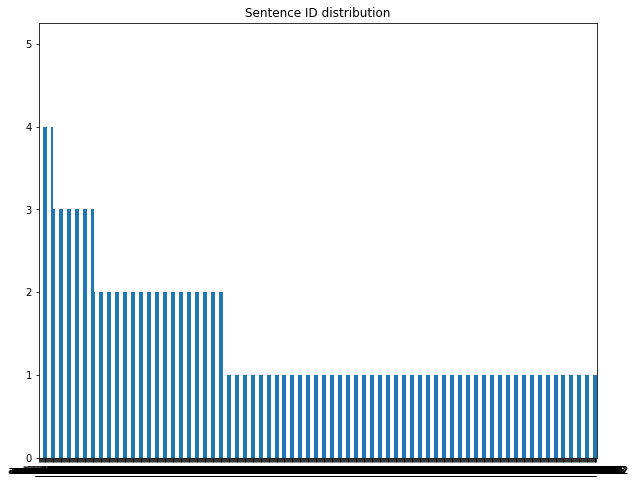

In [64]:
final_df.sentence_id.value_counts().plot(kind='bar', figsize=(10, 8), xticks=[])
plt.title("Sentence ID distribution")

In [65]:
final_df.speaker_id.value_counts()

0007    69
0041    43
0025    43
0038    38
0006    34
        ..
0354     1
0880     1
1049     1
0260     1
0580     1
Name: speaker_id, Length: 77, dtype: int64

Text(0.5, 1.0, 'Unique speaker ids')

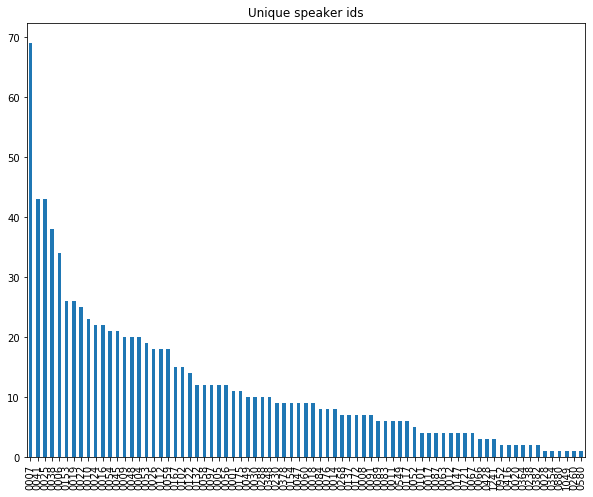

In [66]:
final_df.speaker_id.value_counts().plot(kind='bar', figsize=(10, 8))
plt.title("Unique speaker ids")

In [67]:
final_df.gender.value_counts()

M    576
F    343
Name: gender, dtype: int64

Text(0.5, 1.0, 'Gender distribution')

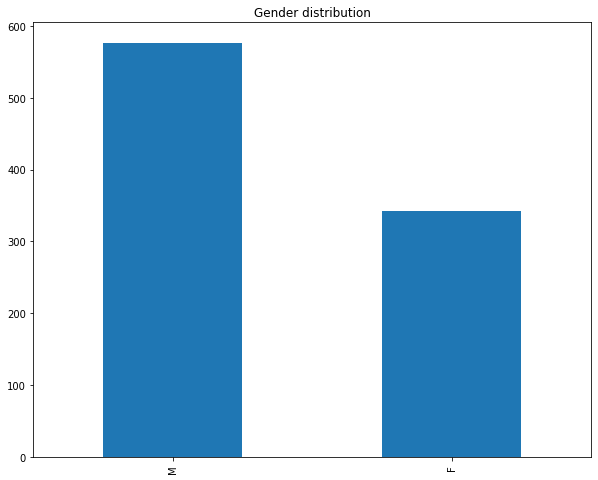

In [68]:
final_df.gender.value_counts().plot(kind='bar', figsize=(10, 8))
plt.title("Gender distribution")

Text(0.5, 1.0, 'Native Language distribution')

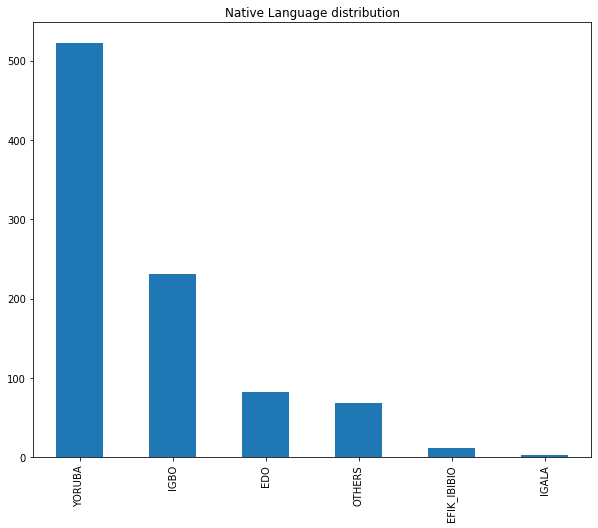

In [69]:
final_df.nativeLanguage.value_counts().plot(kind='bar', figsize=(10, 8))
plt.title("Native Language distribution")

Text(0.5, 1.0, 'Fluent Language distribution')

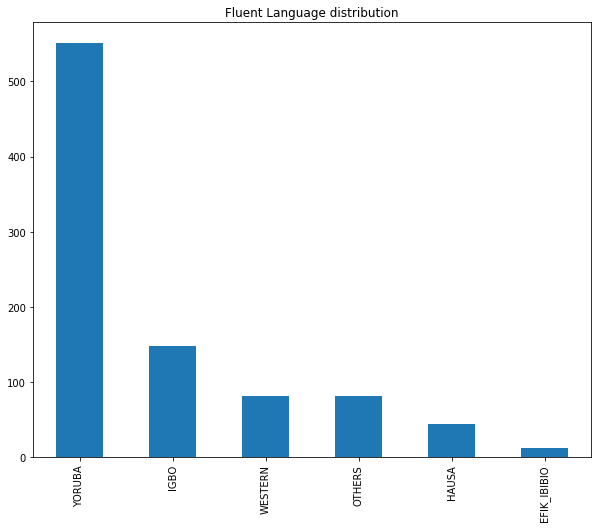

In [70]:
final_df.fluentLanguage.value_counts().plot(kind='bar', figsize=(10, 8))
plt.title("Fluent Language distribution")

From this, we can see that we need to collect more data from different ethnic groups, especially Hausa (an important ethnic group) which is totally missing. We need to approach more Hausa native speakers as well as Igbo speakers for our next round of data collection.

In [71]:
# Used to rename the files
final_df.loc[:, ['audio_filename', 'new_filename']].apply(lambda x: x+'.wav').to_csv('sautidb_filename_newname.csv', index=None, header=False)

In [72]:
final_df.loc[:, ['audio_filename']].apply(lambda x: x+'.wav').to_csv('sautidb_filename.csv', index=None, header=False)

**Listen to samples**

In [73]:
import soundfile as sf
import IPython.display as ipd

In [74]:
female_speaker_filename = final_df[final_df.gender=='F'].audio_filename.values[0]
male_speaker_filename = final_df[final_df.gender=='M'].audio_filename.values[0]

In [75]:
audio1, sr1 = sf.read('/Users/s3nsei/sauti_wavs/{}.wav'.format(female_speaker_filename))
print(audio1.shape, sr1)

(175680,) 48000


In [76]:
# female audio
ipd.Audio(audio1, rate=sr1)

In [77]:
audio2, sr2 = sf.read('/Users/s3nsei/sauti_wavs/{}.wav'.format(male_speaker_filename))
print(audio2.shape, sr2)

(273600,) 48000


In [78]:
# male audio
ipd.Audio(audio2, rate=sr2)